<a href="https://colab.research.google.com/github/nebojsa-bozanic/OSuM/blob/master/OSuM_Vezba13/OSuM_Vezba13/OSuM_vezba_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 13: Segmentacija primenom praga

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, osum, scipy.ndimage.convolve1d, scipy.signal.find_peaks

In [1]:
!git clone https://github.com/nebojsa-bozanic/OSuM.git
%cd /content/OSuM/OSuM_Vezba13/OSuM_Vezba13

fatal: destination path 'OSuM' already exists and is not an empty directory.
/content/OSuM/OSuM_Vezba13/OSuM_Vezba13


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import osum
from scipy.ndimage import convolve1d
from scipy.signal import find_peaks

# 1. Traženje praga za segmentaciju analizom histograma

1.1 U skripti v13_1.py u promenljivu im učitati jednu od slika mr_0X.png. Prikazati sliku. Cilj je segmentacija bele moždane mase iz MRI slika glave. Bela masa je prilično homogeno tkivo koje se nalazi u središnjem delu mozga i karakteriše je visok intenzitet u MRI T1 slikama. Zato se da lako segmentirati kroz jednostavnu klasifikaciju intenziteta.

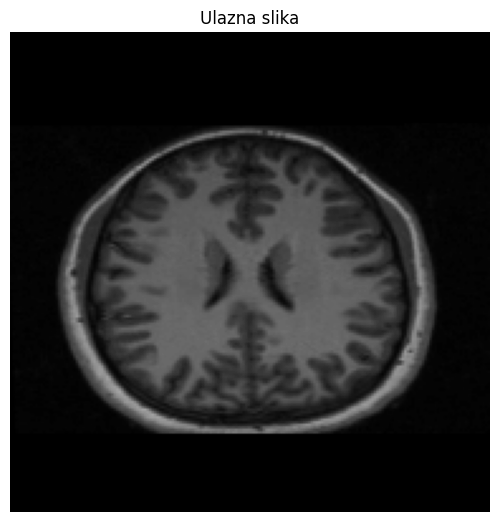

In [3]:
# 1.1
im = cv2.imread('mr_01.png', cv2.IMREAD_GRAYSCALE)
osum.disp_im(im, title='Ulazna slika')

1.2 Napraviti i prikazati histogram slike im. Koliko modova ima histogram?

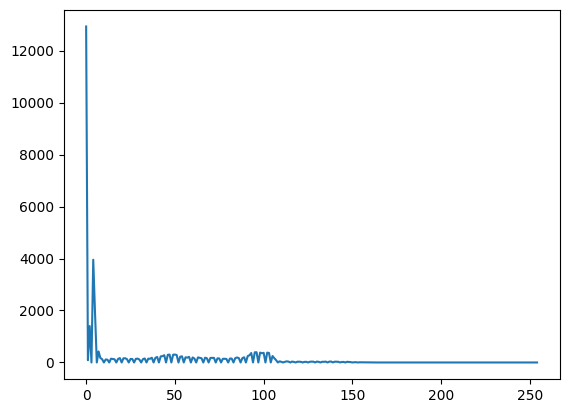

In [4]:
# 1.2
h, g = np.histogram(im, np.arange(0, 256))
plt.figure()
plt.plot(g[:-1], h)

1.3 Na osnovu izgleda histograma izaberite donji prag t1 i gornji prag t2 za koje vam se čini da će najbolje odvojiti belu masu od ostalih tkiva. Podeliti sliku na dva segmenta pomoću pragova (binarna slika koja je 1 tamo gde je bela masa, a 0 drugde). Da li vam se čini da je segmentacija dobra?

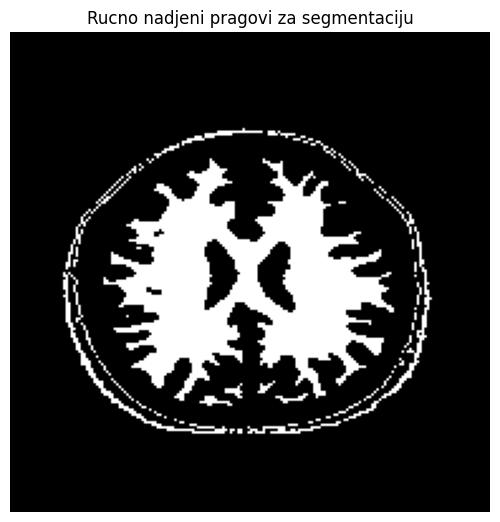

In [5]:
# 1.3
t1 = 75
t2 = 115
im_s1 = np.logical_and((im>t1), (im<t2))
osum.disp_im(im_s1, lmin=0, lmax=1, title='Rucno nadjeni pragovi za segmentaciju')

1.4 Sada ćemo pokušati da automatski pronađemo prag iz histograma. Prvi korak je ublažavanje, tj. NF filtriranje (Gausovim filtrom) histograma kako bi se suzbile sitne lokalne varijacije.

In [6]:
# 1.4
f, x_osa = osum.gaussian(21, 4)
# plt.figure()
# plt.plot(x_osa, f)
# plt.show()
h_f = convolve1d(h, f, mode='nearest')

1.5 Pronaći pikove u isfiltriranom histogramu upotrebom funkcije find_peaks. Prilagoditi parametre (height, distance, prominence…) tako da funkcija pronađe lokalne maksimume (pikove) modova sive mase i bele mase. Prikazati pikove na histogramu.

Text(0.5, 1.0, 'Lokalni maksimumi na ublazenom histogramu')

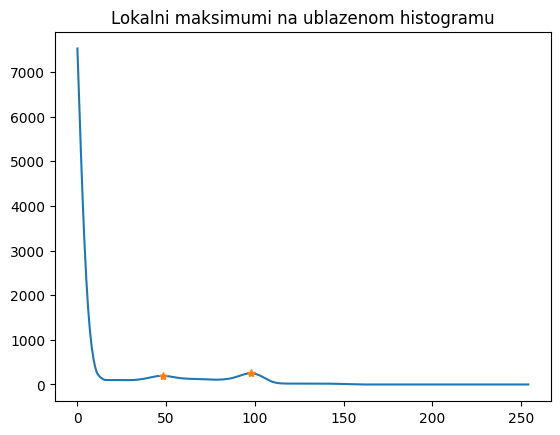

In [7]:
# 1.5
peaks, props = find_peaks(h_f, distance=30, prominence=50)
plt.figure()
plt.plot(g[:-1], h_f)
plt.plot(peaks, h_f[peaks], marker='*', linestyle='None')
plt.title('Lokalni maksimumi na ublazenom histogramu')

1.6 Prag za segmentaciju izračunati kao srednju vrednost između intenziteta na kojem se nalazi lokalni maksimum moda sive mase i lokalni maksimum moda bele mase. Segmentirati sliku upotrebom ovog praga. Da li je pronađeni prag blizu ručno definisanog praga t1?

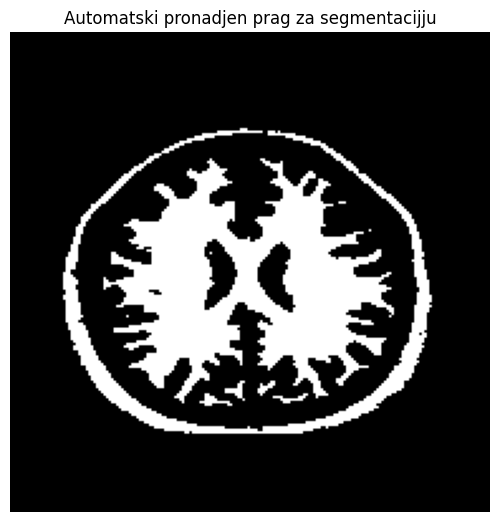

In [8]:
# 1.6
vals = g[peaks]
tr = (g[peaks[0]]+g[peaks[1]])/2

im_s2 = im>tr
osum.disp_im(im_s2, lmin=0, lmax=1, title='Automatski pronadjen prag za segmentacijju')

# 2. Procena kvaliteta segmentacije i optimalni prag

2.1 Da bismo proverili kvalitet naše segmentacije potrebno je da segmentiranu sliku uporedimo sa referentnom slikom. Svaka mr_0X.png slika ima odgovarajuću
lab_0X.png sliku na kojoj su ručno označeni različiti segmenti. Prikazati odgovarajuću lab_0X.png sliku. Koliko segmenata je označeno na slici?

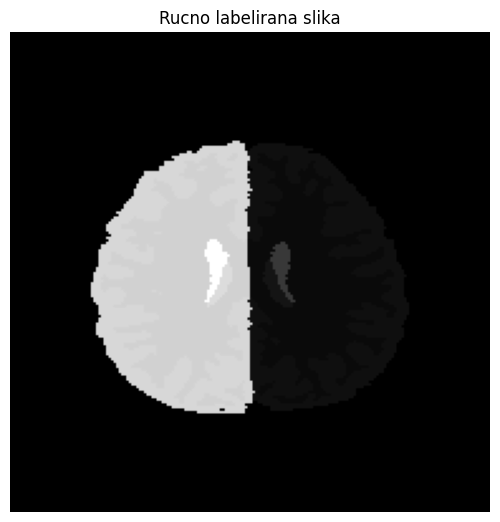

In [9]:
# 2.1
lab = cv2.imread('lab_01.png', cv2.IMREAD_GRAYSCALE)
osum.disp_im(lab, lmin=lab.min(), lmax=lab.max(), title='Rucno labelirana slika')

labs = np.unique(lab)

2.2 Izdvojiti belu masu desne i leve hemisfere u referentnu sliku lS.

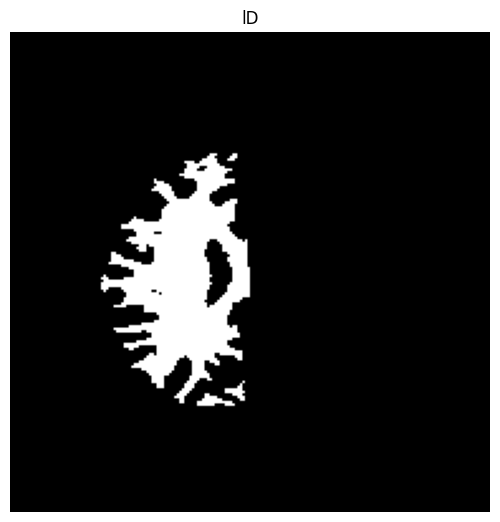

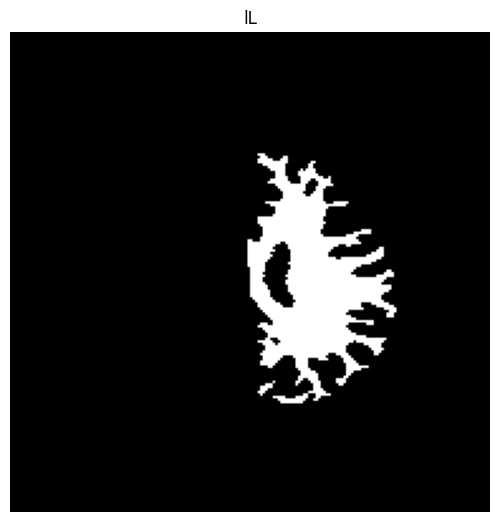

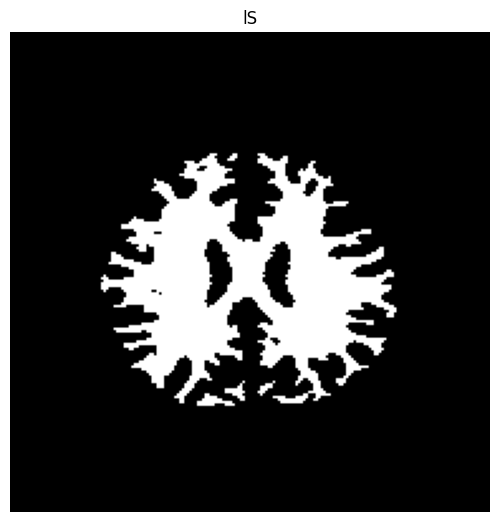

In [10]:
# 2.2
lD = lab == 41  # bela masa desne hemisfere
lL = lab == 2  # bela masa leve hemisfere
lS = np.logical_or(lL, lD)
osum.disp_im(lD, title='lD', lmin=0, lmax=1)
osum.disp_im(lL, title='lL', lmin=0, lmax=1)
osum.disp_im(lS, title='lS', lmin=0, lmax=1)

2.3 U skripti osum.py napraviti funkciju tanimoto koja kao ulaz uzima dve binarne slike, a vraća njihov Tanimoto presek kao skalarnu vrednost. Tanimoto presek je količnik preseka dva skupa i njihove unije. Veća vrednost ukazuje na veću sličnost između slika. U slučaju binarnih slika, viđenih kao skupova, presek je suma minimalnih vrednosti na svakom pikselu (ili logičko ∧), dok je unija maksimalna vrednost (ili logičko ∨).

2.4 Izračunati tanimoto presek između referentne slike lS i slika dobijenih u 1.3 i 1.6. Da li slike liče?

In [11]:
# 2.4
t1 = osum.tanimoto(lS, im_s1)
t2 = osum.tanimoto(lS, im_s2)

2.5 Prikazati sliku apsolutnih razlika između referentne slike i slika iz 1.3 i 1.6. Na kojim regionima je došlo do najvećih grešaka u segmentaciji?

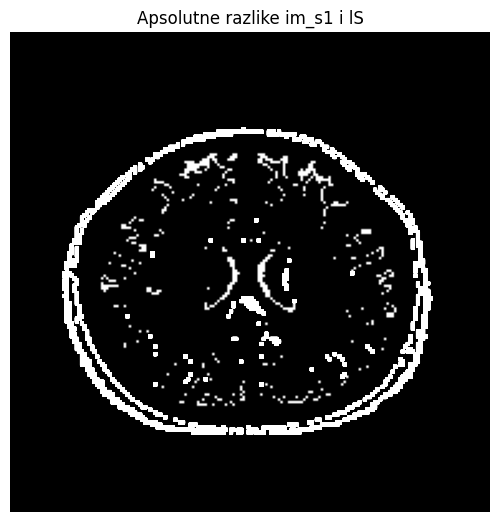

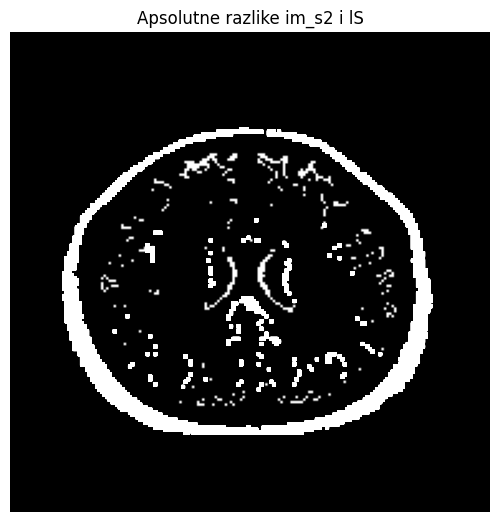

In [12]:
# 2.5
abs1 = np.abs(np.uint8(lS)-np.uint8(im_s1))
osum.disp_im(abs1, lmin=0, lmax=1, title='Apsolutne razlike im_s1 i lS')
abs2 = np.abs(np.uint8(lS)-np.uint8(im_s2))
osum.disp_im(abs2, lmin=0, lmax=1, title='Apsolutne razlike im_s2 i lS')

2.6 Sada ćemo pokušati da pronađemo optimalni prag za segmentaciju. Raditi
segmentaciju u petlji čija je promenljiva vrednost. Segmentiranu sliku onda uporediti sa referentnom pomoću tanimoto indeksa. Optimalni prag je onaj za koji je dobiven najveći tanimoto indeks. Koliko se taj prag razlikuje od onog iz 1.6? Prikazati sliku nakon segmentacije.

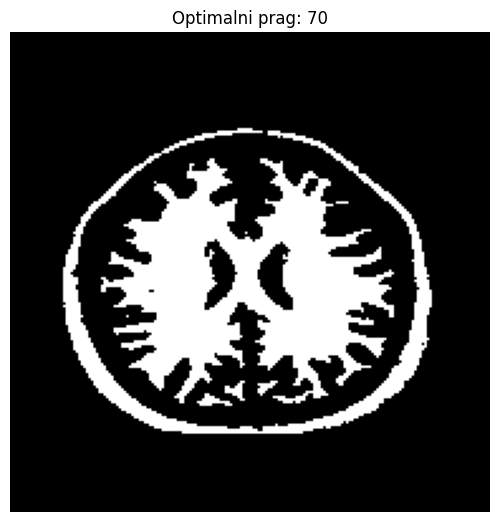

In [13]:
# 2.6
t = []
pr = []
for p in range(im.min()+10, im.max()-9, 10):
    imS = im>p
    t.append(osum.tanimoto(imS, lS))
    pr.append(p)

ind = np.argmax(t)
maxT = t[ind]
optP = pr[ind]

im_s3 = im>optP
osum.disp_im(im_s3, lmin=0, lmax=1, title='Optimalni prag: '+str(optP))

# 3. Traženje praga za segmentaciju analizom ivičnih piksela

3.1 U skripti v13_2.py u promenljivu im učitati sliku hand.tif. Smanjiti rezoluciju slike, npr. na 2 nivo Gausove piramide i tu sliku nazvati im_g. Prikazati im i im_g.

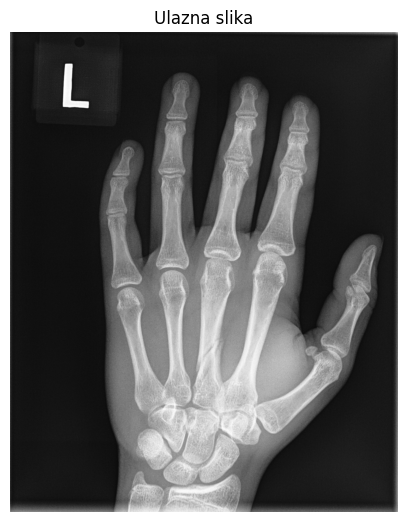

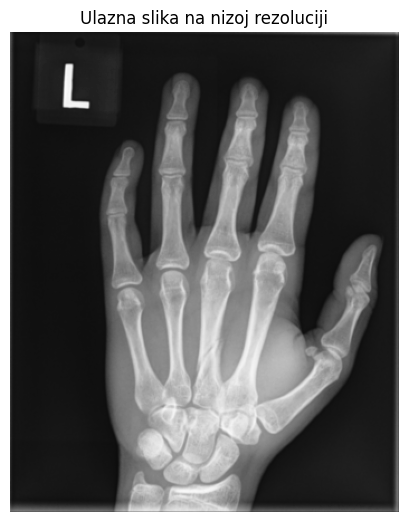

In [14]:
# 3.1
im = cv2.imread('hand.tif', cv2.IMREAD_GRAYSCALE)
# im = cv2.imread('shoulder.png', cv2.IMREAD_GRAYSCALE)  # 3.10
osum.disp_im(im, title='Ulazna slika')

LPyr, GPyr, Res, size_vec = osum.im_pyr_decomp(im, 3)
im_g = GPyr[2]
osum.disp_im(im_g, 'Ulazna slika na nizoj rezoluciji')

3.2 Izračunati gradijente po x i y, magnitudu gradijenta i orijentaciju koristeći funkciju osum.sobel_grad. Prikazati sve dobijene slike i izanalizirati šta koja predstavlja.

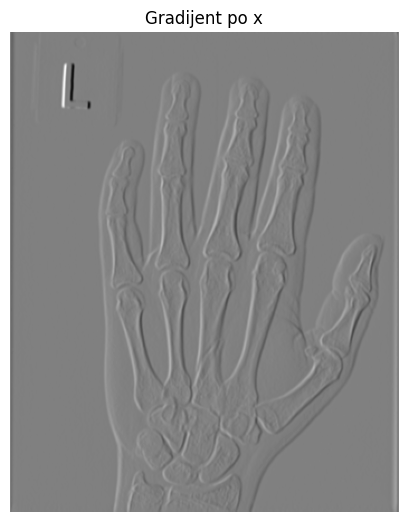

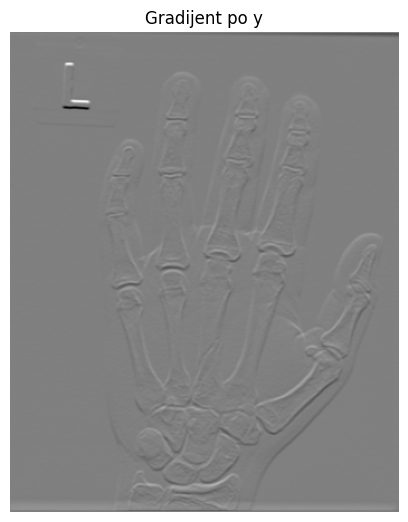

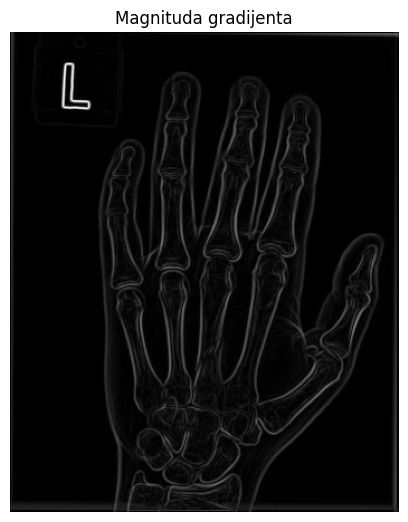

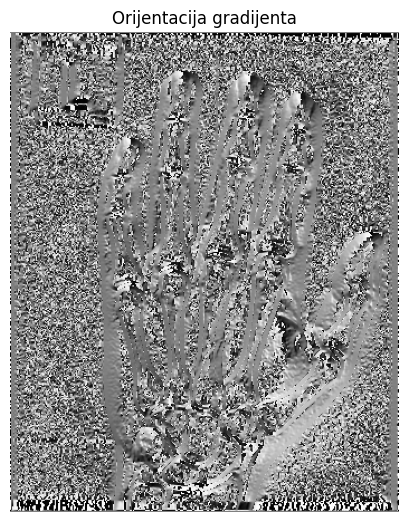

In [15]:
# 3.2
sx, sy, g, o = osum.sobel_grad(im_g)
osum.disp_im(sx, title='Gradijent po x', lmin=sx.min(), lmax=sx.max())
osum.disp_im(sy, title='Gradijent po y', lmin=sy.min(), lmax=sy.max())
osum.disp_im(g, title='Magnituda gradijenta', lmin=g.min(), lmax=g.max())
osum.disp_im(o, title='Orijentacija gradijenta', lmin=o.min(), lmax=o.max())

3.3 Normalizovati magnitudu gradijenta na opseg [0, 1] i napraviti binarnu masku im_gs gde su prikazane lokacije na kojima se nalazi jak gradijent, odnosno gde je magnitude gradijenta veća od 0.1 (vrednost može da se menja). Prikazati tu masku.

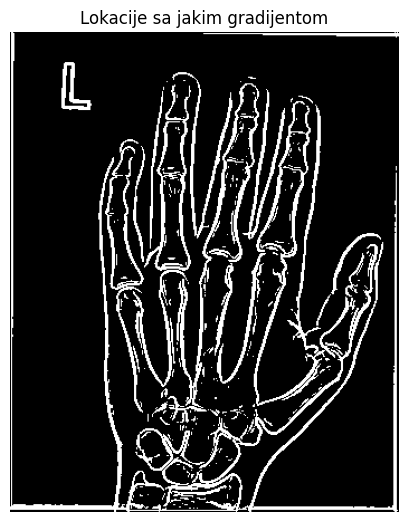

In [16]:
# 3.3
g = osum.im_norm(g)
t = 0.1
im_gs = g>t
osum.disp_im(im_gs, lmin=0, lmax=1, title='Lokacije sa jakim gradijentom')

3.4 Primeniti morfološku operaciju dilatacije na im_gs koristeći kvadrat 3x3 kao strukturni element. Tako dobijena slika d predstavlja ivice i susedne piksele oko ivica.

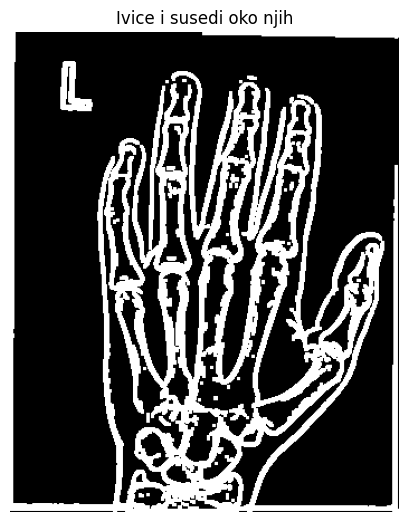

In [17]:
# 3.4
d = cv2.dilate(np.uint8(im_gs), np.ones((3,3)))
osum.disp_im(d, lmin=0, lmax=1, title='Ivice i susedi oko njih')

3.5 Napraviti binarnu sliku d2 na kojoj su predstavljeni samo susedni pikseli oko ivica. To se dobija operacijom logičko i između d i invertovane im_gs.

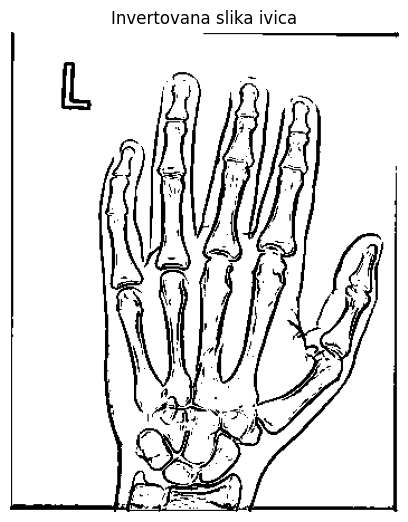

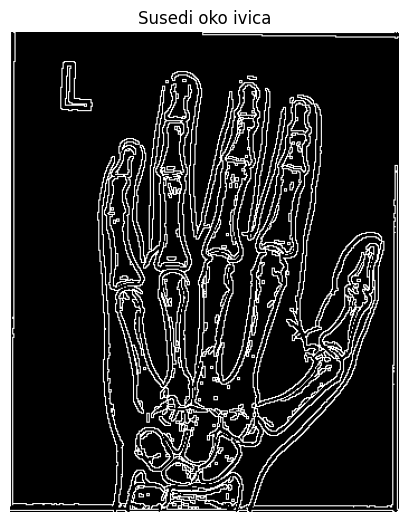

In [18]:
# 3.5
d2 = np.logical_and(d, np.logical_not(im_gs))
osum.disp_im(np.logical_not(im_gs), lmin=0, lmax=1, title='Invertovana slika ivica')
osum.disp_im(d2, lmin=0, lmax=1, title='Susedi oko ivica')

3.6 Prag t0 se procenjuje kao srednja vrednost susednih piksela, tj. srednja vrednost na lokacijama definisanim u d2.

In [19]:
# 3.6
t0 = np.mean(im_g[d2])

3.7 Napraviti binarne mape g_svetlo i g_tamno koje predstavljaju lokacije piksela koji imaju veći (anatomija) odnosno manji intenzitet (pozadina) od t0.

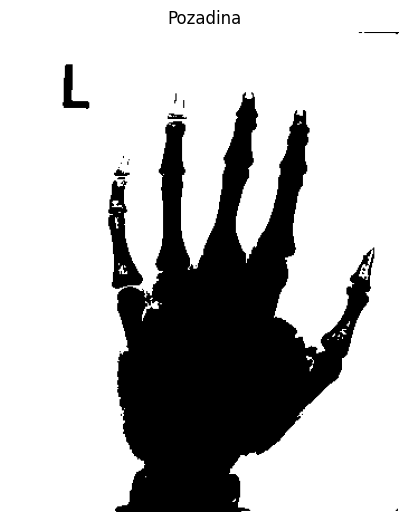

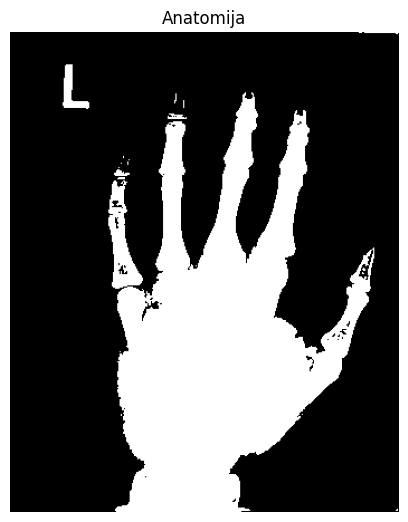

In [20]:
# 3.7
g_tamno = im_g<t0
g_svetlo = im_g>=t0
osum.disp_im(g_tamno, lmin=0, lmax=1, title='Pozadina')
osum.disp_im(g_svetlo, lmin=0, lmax=1, title='Anatomija')


3.8 Prag t_svetlo se računa kao prosečna vrednost na lokacijama definisanim u g_svetlo, a t_tamno kao prosečna vrednost na lokacijama definisanim u g_tamno. Konačni prag za segmentaciju tc dobija se kao prosek t_svetlo i t_tamno.

In [21]:
# 3.8
t_svetlo = np.mean(im_g[g_svetlo])
t_tamno = np.mean(im_g[g_tamno])
tc = (t_svetlo+t_tamno)/2

3.9 Primeniti prag na sliku im i prikazati rezultat segmentacije. Da li je rezultat zadovoljavajuć?

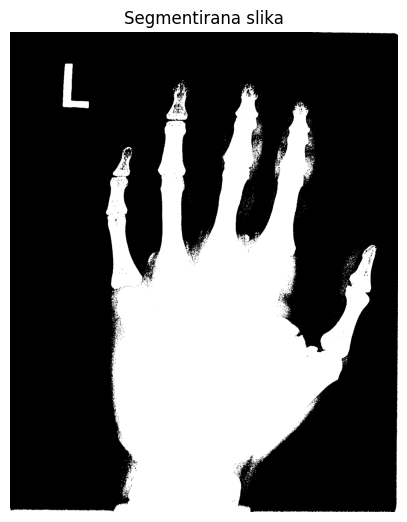

In [22]:
# 3.9
im_s = im>tc
osum.disp_im(im>tc, lmin=0, lmax=1, title='Segmentirana slika')

3.10 Ponoviti algoritam za sliku shoulder.png. Da li je rezultat segmentacije
zadovoljavajuć?